## Creating Time Window
Info:

- window size: 20 sec
- sliding step : 1 sec = 50 Hz
- overlapping windows
- size: 1000samples = 20 seconds * 50 Hz  
- every participant has 63000 samples
- each window does

In [12]:
import numpy as np
import pandas as pd

# Load the preprocessed data
data = pd.read_csv('Data/preprocessed_data.csv')
data.head()


,time_stamp,participant,activity,accel_magnitude
0,1.390000e+12,1,walking,15.043465
1,1.390000e+12,1,walking,14.097451
2,1.390000e+12,1,walking,14.744242
3,1.390000e+12,1,walking,13.321392
4,1.390000e+12,1,walking,12.133143


### Overlapping windows with 1-second steps and 20-second window length


In [13]:
# Define window size and step size
window_size = 1000   # 20 seconds * 50 Hz
step_size = 50       # 1 second * 50 Hz

# Initialize a list to hold the windows and their corresponding majority activities
windows = []
activities = []

# Create sliding windows
for start in range(0, len(data) - window_size + 1, step_size):
    end = start + window_size
    window = data.iloc[start:end]
    windows.append(window)
    majority_activity = window['activity'].mode()[0]  # Get the majority activity
    activities.append(majority_activity)

print(f'Total windows created: {len(windows)}')

Total windows created: 12581


In [14]:
# Convert the list of windows and activities into a DataFrame
windowed_data = pd.DataFrame({'window': windows, 'majority_activity': activities})

# Display the first few entries of the windowed data
windowed_data.sample(5)

,window,majority_activity
9254,time_stamp participant activity ac...,jogging
12437,time_stamp participant activity ...,downstairs
10324,time_stamp participant activity a...,standing
6372,time_stamp participant activity ac...,walking
529,time_stamp participant activity acc...,jogging


In [15]:
from scipy.stats import skew
from scipy.signal import welch

def extract_features(window, fs=50):
    x = window['accel_magnitude'].values.astype(float)
    features = {}
    features['mean'] = np.mean(x)
    features['std'] = np.std(x)
    features['skewness'] = skew(x)
    features['max'] = np.max(x)
    features['min'] = np.min(x)
    features['range'] = np.max(x) - np.min(x)
    # Welch's method for power spectral density
    f, Pxx = welch(x, fs=fs)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    
    # Μπορείς να κρατήσεις όλο το φάσμα ή π.χ. το άθροισμα ή το μέγιστο
    features['psd_sum'] = np.sum(Pxx)
    features['psd_max'] = np.max(Pxx)
    # Αν θέλεις όλο το φάσμα:
    # for i, val in enumerate(Pxx):
    #     features[f'psd_{i}'] = val
    return features

# Εξαγωγή χαρακτηριστικών για όλα τα παράθυρα
feature_list = []
for window in windows:
    feats = extract_features(window)
    feature_list.append(feats)

features_df = pd.DataFrame(feature_list)
features_df['majority_activity'] = activities
features_df.sample(5)

,mean,std,skewness,max,min,range,psd_sum,psd_max,majority_activity
13,11.781952,4.969839,0.423585,28.250613,2.114711,26.135902,129.626740,20.493528,walking
1609,11.665911,5.032056,1.120883,29.772789,1.726994,28.045795,94.279620,24.065790,standing
333,10.190933,0.027269,0.332354,10.370569,10.090074,0.280495,0.003457,0.000081,standing
474,13.261647,7.020009,-0.014769,28.028536,0.413128,27.615408,253.887460,89.750585,jogging
2692,10.525444,2.418699,0.508052,20.084304,3.164034,16.920270,32.029740,5.495594,standing


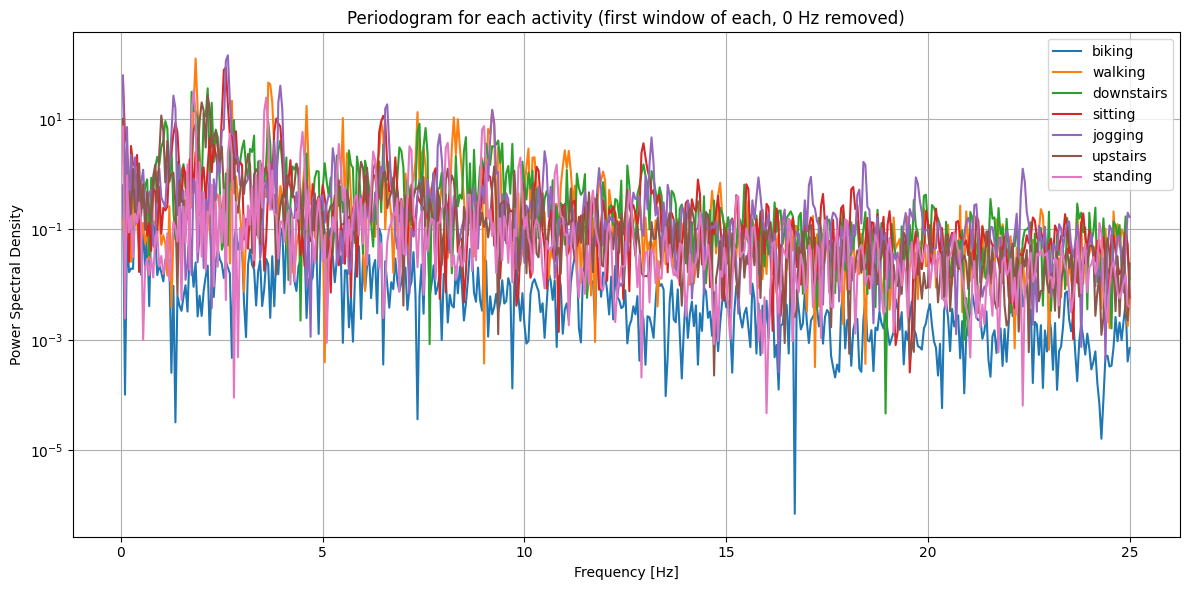

In [16]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = periodogram(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Periodogram for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

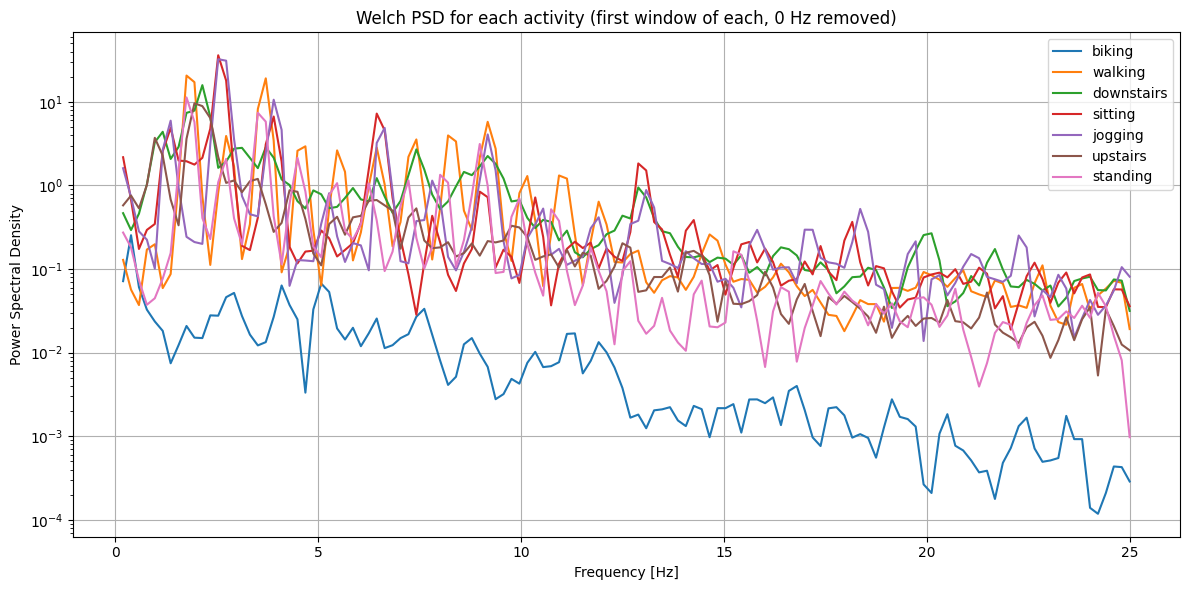

In [17]:
from scipy.signal import welch
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = welch(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Welch PSD for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Need to decide how this feature to be used

In [18]:
# Save the windowed data to a new CSV file
output_windowed_file_path = 'Data/windowed_data.csv'
windowed_data.to_csv(output_windowed_file_path, index=False)
print(f'Windowed data saved to {output_windowed_file_path}')

Windowed data saved to Data/windowed_data.csv


In [19]:
# Ensure 'participant' column exists in features_df before saving

if 'participant' not in features_df.columns:
    # Assign participant to each window based on the original data index
    # Each window is a DataFrame, so get the participant from the first row of each window
    participants = [int(window['participant'].iloc[0]) for window in windows]
    features_df['participant'] = participants

# Save the extracted features to a new CSV file
output_features_file_path = 'Data/features_df.csv'
features_df.to_csv(output_features_file_path, index=False)
print(f'Features DataFrame saved to {output_features_file_path}')

Features DataFrame saved to Data/features_df.csv
